# Температура стали

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Нам предстоит построить модель, которая предскажет температуру стали.

#### Описание этапа обработки
Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 
Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).
Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.
Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).

#### Описание данных

Данные состоят из файлов, полученных из разных источников:
- data_arc_new.csv — данные об электродах;
- data_bulk_new.csv — данные о подаче сыпучих материалов (объём);
- data_bulk_time_new.csv — данные о подаче сыпучих материалов (время);
- data_gas_new.csv — данные о продувке сплава газом;
- data_temp_new.csv — результаты измерения температуры;
- data_wire_new.csv — данные о проволочных материалах (объём);
- data_wire_time_new.csv — данные о проволочных материалах (время).

Во всех файлах столбец key содержит номер партии. В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

#### План работы
- Исследовательский анализ данных:
  * загрузить данные;
  * осмотреть данные: первые несколько строк, общую информацию, статистику;
  * сделать выводы по каждому датафрейму.
- Предобработка данных:
  * привести данные к нужным типам;
  * удалить или исправить аномалии (например, восстановить отрицательную Q по коэффициенту мощности);
  * удалить или заполнить пропуски, при необходимости удаления удалять всю партию целиком, а не только запись с пропуском;
  * добавить признаки (например, время начала и конца обработки партии, полную мощность S);
  * убрать из рассмотрения потенциально неиформативные признаки (например, время добавок);
  * сгруппировать данные по номеру партии, причем оставить только те партии, которые входят во все датафреймы;
  * объединить сгруппированные датафреймы в один;
  * "отшлифовать" этот итоговый датафрейм: создать новые потенциально полезные признаки, удалить коррелирующие;
  * разделить датафрейм на выборки 3:1; 
  * сделать вывод по предобработке.
- Построение и подбор моделей:
  * построить pipeline (масштабирование, кросс-валидация);
  * подобрать оптимальные гиперпараметры по крайней мере двух моделей;
  * получить метрики;
  * выбрать модель с лучшим значением метрики;
  * сделать вывод по моделям.
- Тестирование выбранной модели:
  * протестировать модель на отложенной выборке;
  * сравнить с константной моделью;
  * исследовать важность признаков;
  * сделать вывод.
- Написать отчет.

Целевой признак - последняя измеренная температура в партии. Критерий успеха: значение метрики **MAE** на тестовой выборке должно быть не больше **6.8**.

### Исследовательский анализ данных

In [1]:
!pip install xgboost

In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler 
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, make_scorer, r2_score

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
import xgboost as xgb
from sklearn.dummy import DummyRegressor

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 50)

In [3]:
RANDOM_STATE = 250923

In [4]:
arc_pth_loc = 'data_arc_new.csv'
bulk_pth_loc = 'data_bulk_new.csv'
bulk_time_pth_loc = 'data_bulk_time_new.csv'
gas_pth_loc = 'data_gas_new.csv'
temp_pth_loc = 'data_temp_new.csv'
wire_pth_loc = 'data_wire_new.csv'
wire_time_pth_loc = 'data_wire_time_new.csv'

pth = '/datasets/'

if os.path.exists(arc_pth_loc):
    arc = pd.read_csv(arc_pth_loc)
    bulk = pd.read_csv(bulk_pth_loc)
    bulk_time = pd.read_csv(bulk_time_pth_loc)
    gas = pd.read_csv(gas_pth_loc)
    temp = pd.read_csv(temp_pth_loc)
    wire = pd.read_csv(wire_pth_loc)
    wire_time = pd.read_csv(wire_time_pth_loc)
    print('Local')
    
elif os.path.exists(pth+arc_pth_loc):
    arc = pd.read_csv(pth+arc_pth_loc)
    bulk = pd.read_csv(pth+bulk_pth_loc)
    bulk_time = pd.read_csv(pth+bulk_time_pth_loc)
    gas = pd.read_csv(pth+gas_pth_loc)
    temp = pd.read_csv(pth+temp_pth_loc)
    wire = pd.read_csv(pth+wire_pth_loc)
    wire_time = pd.read_csv(pth+wire_time_pth_loc)
    print('Server')
else:
    print('smth went wrong')

Server


In [5]:
#функция для первичного обзора датафрейма
def first_look (df):
    display(df.head(3))
    df.info()
    display(df.describe(include='all'))
    print('Уникальных номеров партии:', len(df['key'].unique()))

##### Электроды

In [6]:
first_look(arc)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
count,14876.000000,14876,14876,14876.000000,14876.000000
unique,NaN,14876,14876,NaN,NaN
top,NaN,2019-09-03 08:59:17,2019-05-14 12:52:17,NaN,NaN
freq,NaN,1,1,NaN,NaN
mean,1615.220422,NaN,NaN,0.662752,0.438986
std,934.571502,NaN,NaN,0.258885,5.873485
min,1.000000,NaN,NaN,0.223120,-715.479924
25%,806.000000,NaN,NaN,0.467115,0.337175
50%,1617.000000,NaN,NaN,0.599587,0.441639
75%,2429.000000,NaN,NaN,0.830070,0.608201


Уникальных номеров партии: 3214


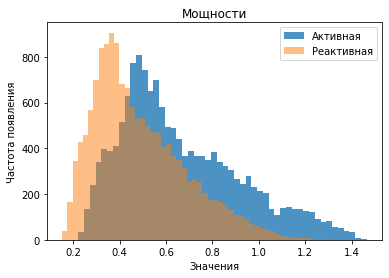

In [7]:
plt.hist(arc['Активная мощность'], bins = 50, alpha = 0.8);
plt.hist(arc[arc['Реактивная мощность']>-2]['Реактивная мощность'], bins = 50, alpha = 0.5);
plt.legend(['Активная', 'Реактивная'], loc='upper right')
plt.title('Мощности');
plt.xlabel('Значения');
plt.ylabel('Частота появления');
plt.show()

In [8]:
print('Самые ранние даты:', '\n', arc['Начало нагрева дугой'].min(), '\n', arc['Конец нагрева дугой'].min())
print('Самые поздние даты:', '\n', arc['Начало нагрева дугой'].max(), '\n', arc['Конец нагрева дугой'].max())

Самые ранние даты: 
 2019-05-03 11:02:14 
 2019-05-03 11:06:02
Самые поздние даты: 
 2019-09-06 17:24:54 
 2019-09-06 17:26:15


14876 объектов, пропусков нет, у дат нужно поменять тип данных, минимальное значение столбца "Реактивная мощность" явно ошибочно (поэтому график построен без него). Реактивная, в среднем, меньше активной, так и должно быть. Временные рамки - с мая по сентябрь 2019г.

In [9]:
arc_eda = {'длина': len(arc), 'пропуски': 'нет', 'тип данных': 'есть', 'аномалии': 'есть', 
           'партий': len(arc['key'].unique())}

<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success"><b> комментарий тимлида - план v1 </b>  
👍 </div>

##### Сыпучие материалы

In [10]:
first_look(bulk)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


Уникальных номеров партии: 3129


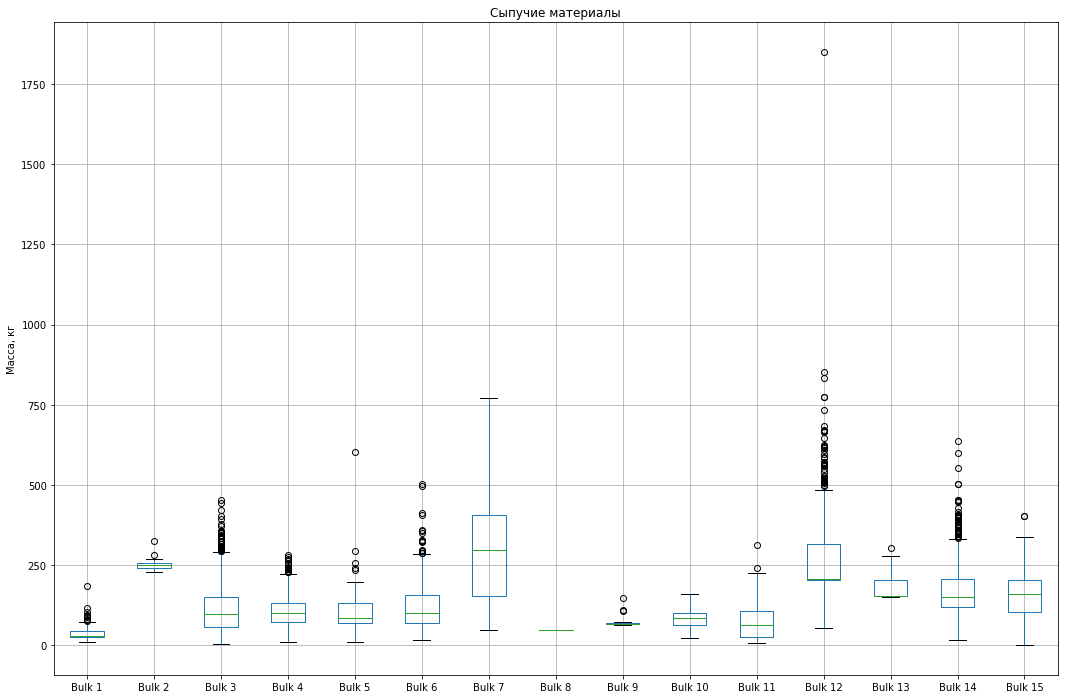

In [11]:
plot = bulk.loc[:, bulk.columns !='key'].boxplot(figsize = (18,12));
plt.title('Сыпучие материалы');
plt.ylabel('Масса, кг')
plt.show()

В столбцах массы добавленных примесей. Много пропусков, их заменим на 0 (если нет данных, значит, не добавляли), типы данных в порядке, номеров партии меньше, чем в *'arc'*. Аномалии в глаза не бросаются - значения положительны и не превышают 2000.

Если мощности выражены в МВА, то порядок объема печи - десятки тонн. Обычная углеродистая сталь содержит до 2% углерода, то есть, например: 80т стали, 2% это 80х0,02=1.6т=1600кг углерода. Значит, предполжительно, добавки даны в килограммах.

Есть добавки со значительным количеством выбросов, есть одно подозрительно большое значение у добавки № 12. Посмотрим на эту партию.

In [12]:
display(bulk[bulk['Bulk 12']>1000])
arc[arc['key']==322]

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
303,322,185.0,NaN,101.0,58.0,NaN,NaN,406.0,NaN,NaN,NaN,NaN,1849.0,NaN,636.0,NaN


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
1487,322,2019-05-15 21:12:28,2019-05-15 21:14:57,0.248241,0.187737
1488,322,2019-05-15 21:17:00,2019-05-15 21:21:04,0.464677,0.346769
1489,322,2019-05-15 21:26:09,2019-05-15 21:31:26,0.328053,0.279597
1490,322,2019-05-15 21:40:12,2019-05-15 21:41:43,1.054529,0.814842
1491,322,2019-05-15 21:46:57,2019-05-15 21:49:02,0.746207,0.556786
1492,322,2019-05-15 21:51:58,2019-05-15 21:57:28,0.623596,0.461261
1493,322,2019-05-15 22:02:54,2019-05-15 22:04:42,0.893317,0.619611
1494,322,2019-05-15 22:08:33,2019-05-15 22:11:40,1.107495,0.823706
1495,322,2019-05-15 22:14:27,2019-05-15 22:16:19,0.870899,0.685100
1496,322,2019-05-15 22:40:56,2019-05-15 22:42:40,0.612125,0.441813


Много итераций, возможно, в эту партию действительно добавили много примесей: насыпали-нагрели-размешали-повторили. Оставим пока ее. Возможно, удалим, когда будем улучшать метрику.

In [13]:
bulk_eda = {'длина': len(bulk), 'пропуски': 'есть', 'тип данных': 'нет', 'аномалии': 'нет', 'партий': len(bulk['key'].unique())}

In [14]:
first_look(bulk_time)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252,22,1298,1014,77,576,25,1,19,176,177,2450,18,2806,2248
unique,NaN,252,22,1298,1014,77,576,25,1,19,176,177,2450,18,2806,2248
top,NaN,2019-08-28 09:34:30,2019-05-07 22:50:29,2019-05-06 13:38:13,2019-05-07 22:38:43,2019-08-13 11:04:10,2019-05-24 03:42:25,2019-07-20 19:54:13,2019-07-08 17:14:53,2019-07-08 17:23:24,2019-05-24 19:38:09,2019-07-26 00:20:40,2019-06-15 06:18:29,2019-06-30 14:38:12,2019-08-08 13:22:04,2019-08-24 21:23:08
freq,NaN,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
mean,1624.383509,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,933.337642,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,816.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,1622.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,2431.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Уникальных номеров партии: 3129


In [15]:
(bulk.isna()==bulk_time.isna()).sum()

key        3129
Bulk 1     3129
Bulk 2     3129
Bulk 3     3129
Bulk 4     3129
Bulk 5     3129
Bulk 6     3129
Bulk 7     3129
Bulk 8     3129
Bulk 9     3129
Bulk 10    3129
Bulk 11    3129
Bulk 12    3129
Bulk 13    3129
Bulk 14    3129
Bulk 15    3129
dtype: int64

Количество партий совпадает с *bulk*, это хорошо, ведь речь идет про один и тот же процесс. Много пропусков,они полностью совпадают с *bulk*. Данные нужно привести к типу *datetime*.

In [16]:
bulk_time_eda = {'длина': len(bulk_time), 'пропуски': 'есть', 'тип данных': 'есть', 'аномалии': 'нет', 
                 'партий': len(bulk_time['key'].unique())}

##### Газ

In [17]:
first_look(gas)

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


Уникальных номеров партии: 3239


In [18]:
susp_keys_gas = set(gas['key'].unique()) - set(arc['key'].unique())
print('Количество записей о партиях, отсутствующих в arc:', len(gas[gas['key'].isin(susp_keys_gas)]))

Количество записей о партиях, отсутствующих в arc: 27


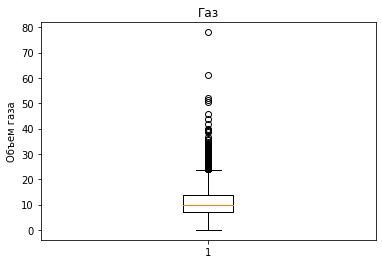

In [19]:
plt.boxplot(gas['Газ 1']);
plt.title('Газ');
plt.ylabel('Объем газа');
plt.show()

Всего один столбец помимо номера партии, пропусков нет, значения положительны, распределение нормальное. Непонятно только, почему "Газ 1", есть еще какой-то газ?

Поиск в интернете дает: "расход инертного газа ... составляет не более 3 кубических метров на одну тонну стали". Значит, предположительно газ указан в кубических метрах.

Есть выбросы сверху. Хотя вполне возможно, что это просто большие партии, стоит проверить.

Уникальных номеров партии здесь больше, чем в *arc*.

In [20]:
gas_eda = {'длина': len(gas), 'пропуски': 'нет', 'тип данных': 'нет', 'аномалии': 'нет', 'партий': len(gas['key'].unique())}

##### Температура

In [21]:
first_look(temp)

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


,key,Время замера,Температура
count,18092.000000,18092,14665.000000
unique,NaN,18092,NaN
top,NaN,2019-09-05 20:12:55,NaN
freq,NaN,1,NaN
mean,1616.460977,NaN,1590.722741
std,934.641385,NaN,20.394381
min,1.000000,NaN,1191.000000
25%,807.750000,NaN,1580.000000
50%,1618.000000,NaN,1590.000000
75%,2429.000000,NaN,1599.000000


Уникальных номеров партии: 3216


In [22]:
susp_keys_temp = set(temp['key'].unique()) - set(arc['key'].unique())
print('Количество записей о партиях, отсутствующих в arc:', len(temp[temp['key'].isin(susp_keys_temp)]))

Количество записей о партиях, отсутствующих в arc: 2


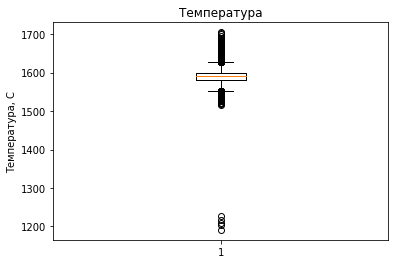

In [23]:
plt.boxplot(temp['Температура'].dropna());
plt.title('Температура');
plt.ylabel('Температура, C');
plt.show()

Два столбца, есть пропуски по температуре. Возможно, эти данные придется удалить, т.к. температура - будущий целевой признак. Время нужно будет перевести в соответствующий тип. Есть две записи о партиях, не указанных в *arc*.

Википедия говорит, что температура плавления стали варьируется от 1450 до 1520. Если сталь застывает в ковше, то ковшу конец. Значит, выбросы у значения 1200 - аномалии.

In [24]:
temp[temp['Температура']< 1500]

,key,Время замера,Температура
4883,867,2019-06-06 08:03:39,1191.0
6784,1214,2019-06-18 08:01:03,1208.0
9050,1619,2019-07-03 02:34:41,1218.0
11495,2052,2019-07-25 08:49:15,1227.0
14283,2561,2019-08-12 18:49:29,1204.0


Таких значений всего 5 штук. Можно будет удалить данные по этим партиям. С пропусками дело хуже.

In [25]:
print('Количество пропусков по температуре:', len(temp['Температура']) - len(temp['Температура'].dropna()))
print('Процент данных с пропуском по температуре:', 
      round(100*(len(temp['Температура']) - len(temp['Температура'].dropna()))/len(temp['Температура']), 1))

Количество пропусков по температуре: 3427
Процент данных с пропуском по температуре: 18.9


Почти 19 процентов данных - это очень много для удаления. Рассмотрим их внимательнее.

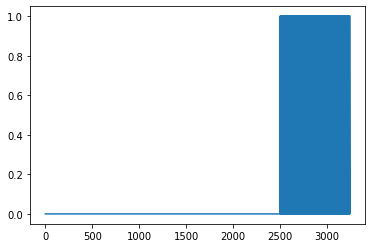

In [26]:
plt.plot(temp['key'], temp['Температура'].isna().astype('int'));

Пропуски появляются после 2500 партии.

In [27]:
temp[temp['key']> 2498].head(30)

,key,Время замера,Температура
13921,2499,2019-08-10 13:33:21,1569.0
13922,2499,2019-08-10 13:41:34,1604.0
13923,2499,2019-08-10 13:46:28,1593.0
13924,2499,2019-08-10 13:54:56,1588.0
13925,2499,2019-08-10 13:58:58,1603.0
13926,2500,2019-08-10 14:04:39,1539.0
13927,2500,2019-08-10 14:13:11,NaN
13928,2500,2019-08-10 14:18:12,NaN
13929,2500,2019-08-10 14:25:53,NaN
13930,2500,2019-08-10 14:29:39,NaN


Судя по всему, после 2500 партии температура снималась только при первом прогоне партии. Проверим это предположение.

In [28]:
print('Количество партий после 2500-й:', len(temp[temp['key']>=2500]['key'].unique()))
print('Количество измерений температуры после 2500-й партии:', temp[temp['key']>=2500]['Температура'].count())

Количество партий после 2500-й: 739
Количество измерений температуры после 2500-й партии: 739


Предположение верно. Придется удалить информацию по этим партиям.

In [29]:
temp_eda = {'длина': len(temp), 'пропуски': 'есть', 'тип данных': 'есть', 'аномалии': 'есть',
            'партий': len(temp['key'].unique())}

##### Проволочные материалы

In [30]:
first_look(wire)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


Уникальных номеров партии: 3081


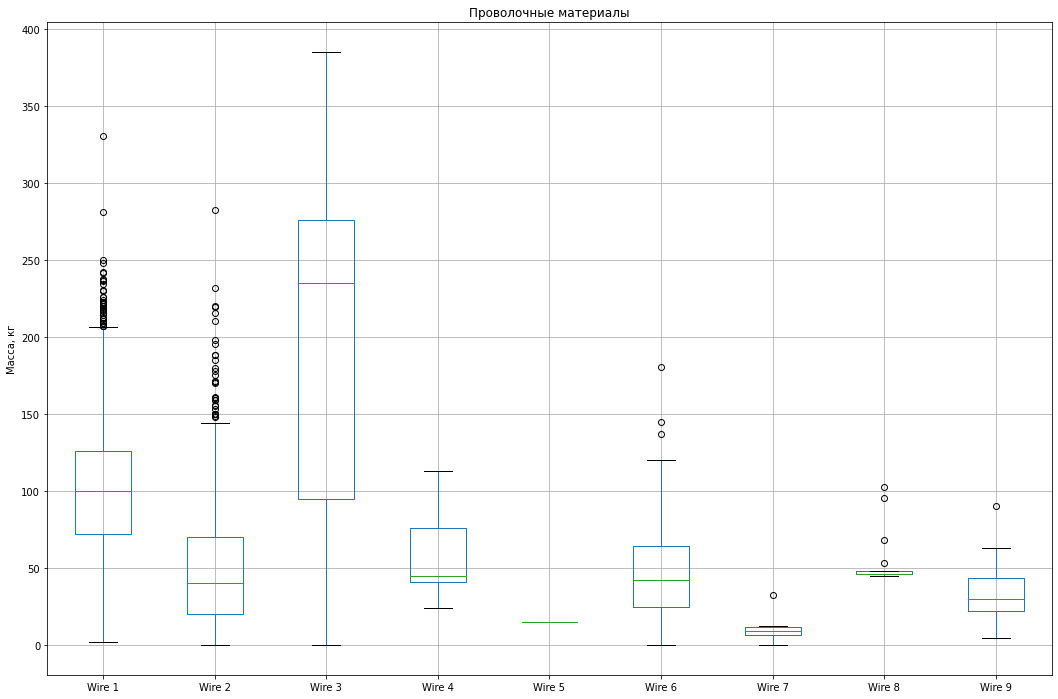

In [31]:
plot = wire.loc[:, wire.columns !='key'].boxplot(figsize = (18,12));
plt.title('Проволочные материалы');
plt.ylabel('Масса, кг')
plt.show()

Проволочные добавки, видимо, тоже в килограммах. Есть пропуски, заменим их на 0 на этапе предобработки, значения положительны и не превышают 400.

Есть выбросы, но ничего криминального. Единичные выбросы у добавок 6-9 можно объяснить небольшим количеством данных вообще (меньше 100 объектов).

In [32]:
wire_eda = {'длина': len(wire), 'пропуски': 'есть', 'тип данных': 'нет', 'аномалии': 'нет', 'партий': len(wire['key'].unique())}

In [33]:
first_look(wire_time)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055,1079,63,14,1,73,11,19,29
unique,NaN,3055,1079,63,14,1,73,11,19,29
top,NaN,2019-06-21 18:05:08,2019-08-07 19:28:01,2019-08-13 07:52:42,2019-05-07 23:21:42,2019-08-13 06:14:30,2019-07-28 15:57:59,2019-08-13 01:13:45,2019-08-16 08:14:32,2019-07-05 00:44:55
freq,NaN,1,1,1,1,1,1,1,1,1
mean,1623.426485,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,932.996726,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,823.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,1619.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,2434.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Уникальных номеров партии: 3081


In [34]:
(wire.isna()==wire_time.isna()).sum()

key       3081
Wire 1    3081
Wire 2    3081
Wire 3    3081
Wire 4    3081
Wire 5    3081
Wire 6    3081
Wire 7    3081
Wire 8    3081
Wire 9    3081
dtype: int64

Времена для проволочных добавок. Пропуски полностью совпадают с *wire*, типы нужно перевести в *datetime*, аномалий не видно.

In [35]:
wire_time_eda = {'длина': len(wire_time), 'пропуски': 'есть', 'тип данных': 'есть', 'аномалии': 'нет', 
                 'партий': len(wire_time['key'].unique())}

_______

In [36]:
eda_review = pd.DataFrame([arc_eda, bulk_eda, bulk_time_eda, gas_eda, temp_eda, wire_eda, wire_time_eda],
                          index = ['arc', 'bulk', 'bulk_time', 'gas', 'temp', 'wire', 'wire_time'])

In [37]:
eda_review

,длина,пропуски,тип данных,аномалии,партий
arc,14876,нет,есть,есть,3214
bulk,3129,есть,нет,нет,3129
bulk_time,3129,есть,есть,нет,3129
gas,3239,нет,нет,нет,3239
temp,18092,есть,есть,есть,3216
wire,3081,есть,нет,нет,3081
wire_time,3081,есть,есть,нет,3081


Было бы неплохо сгруппировать данные по партиям и объединить. Найдем номера партий, входящие во все датасеты.

In [38]:
common_keys = set(arc['key']) & set(bulk['key']) & set(gas['key']) & set(temp['key']) & set(wire['key'])
len(common_keys)

3022

Посмотрим, сколько данных придется удалить, если оставить только общие партии.

In [39]:
new_lengths = []
for df in [arc, bulk, bulk_time, gas, temp, wire, wire_time]:
    new_length = len(df[df['key'].isin(common_keys)])
    new_lengths.append(new_length)
eda_review['новая длина'] = new_lengths
eda_review['процент'] = round(100*(eda_review['длина'] - eda_review['новая длина'])/eda_review['длина'], 2)

In [40]:
eda_review

,длина,пропуски,тип данных,аномалии,партий,новая длина,процент
arc,14876,нет,есть,есть,3214,14200,4.54
bulk,3129,есть,нет,нет,3129,3022,3.42
bulk_time,3129,есть,есть,нет,3129,3022,3.42
gas,3239,нет,нет,нет,3239,3022,6.70
temp,18092,есть,есть,есть,3216,17222,4.81
wire,3081,есть,нет,нет,3081,3022,1.91
wire_time,3081,есть,есть,нет,3081,3022,1.91


Если оставить только общие партии, удалено будет не более 7% данных.

### Предобработка

Таблицы с временами подачи добавок использовать не будем. (т.к. описание проекта говоит, что "Исходное условие задачи заведомо неполное и содержит лишнюю информацию.", а эти времена - первые кандидаты на выброс.)


##### Электроды

В таблице *arc* есть две проблемы: тип данных у времени и аномалии в реактивной мощности. Разберемся с ними по очереди.

In [41]:
arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


In [42]:
arc['Начало нагрева дугой'] = pd.to_datetime(arc['Начало нагрева дугой'], format='%Y-%m-%d %H:%M:%S')
arc['Конец нагрева дугой'] = pd.to_datetime(arc['Конец нагрева дугой'], format='%Y-%m-%d %H:%M:%S')

Найдем средний коэффициент мощности.

In [43]:
tan_fi = (arc['Реактивная мощность']/arc['Активная мощность']).mean()
tan_fi 

0.6666857956474631

Найдем проблемную запись и заменим ошибочное значение реактивной мозности на рассчитанное по активной и коэффициенту.

In [44]:
arc[arc['Реактивная мощность']<0]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924


In [45]:
arc.loc[9780, 'Реактивная мощность'] = arc.loc[9780]['Активная мощность']*tan_fi 

Убедимся, что значение реактивной мощности и тип времен изменились.

In [46]:
arc.loc[9780]

key                                    2116
Начало нагрева дугой    2019-07-28 02:22:08
Конец нагрева дугой     2019-07-28 02:23:57
Активная мощность                  0.705344
Реактивная мощность                0.470243
Name: 9780, dtype: object

Добавим столбец с полной мощностью и оставим только ее, т.к. один этот признак несет в себе всю информацию об энергозатратах.

In [47]:
arc['Полная мощность'] = ((arc['Активная мощность'])**2+(arc['Реактивная мощность'])**2)**0.5
arc = arc.drop(['Активная мощность', 'Реактивная мощность'], axis=1)

Добавим столбец с длительностью нагрева в секундах, а данные о времени начала и конца удалим.

In [48]:
arc['Время нагрева'] = (arc['Конец нагрева дугой'] - arc['Начало нагрева дугой']).astype('timedelta64[s]')
arc = arc.drop(['Конец нагрева дугой', 'Начало нагрева дугой'], axis=1)

Сгруппируем данные по партиям.

In [49]:
arc = arc.groupby('key').agg('sum')

In [50]:
arc.info()
arc.sample(2, random_state= RANDOM_STATE)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 1 to 3241
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Полная мощность  3214 non-null   float64
 1   Время нагрева    3214 non-null   float64
dtypes: float64(2)
memory usage: 75.3 KB


,Полная мощность,Время нагрева
key,,
597,4.215048,358.0
2916,8.922705,1302.0


##### Добавки

Единственная проблема с этими таблицами - пропуски. Заменим их на 0, следуя логике "нет информации, значит, не добавляли".

In [51]:
bulk = bulk.fillna(0)
wire = wire.fillna(0)

In [52]:
bulk.info()
bulk.sample(2, random_state= RANDOM_STATE)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   3129 non-null   float64
 2   Bulk 2   3129 non-null   float64
 3   Bulk 3   3129 non-null   float64
 4   Bulk 4   3129 non-null   float64
 5   Bulk 5   3129 non-null   float64
 6   Bulk 6   3129 non-null   float64
 7   Bulk 7   3129 non-null   float64
 8   Bulk 8   3129 non-null   float64
 9   Bulk 9   3129 non-null   float64
 10  Bulk 10  3129 non-null   float64
 11  Bulk 11  3129 non-null   float64
 12  Bulk 12  3129 non-null   float64
 13  Bulk 13  3129 non-null   float64
 14  Bulk 14  3129 non-null   float64
 15  Bulk 15  3129 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
926,969,0.0,0.0,92.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,135.0,0.0
2293,2376,0.0,0.0,184.0,0.0,0.0,266.0,0.0,0.0,0.0,0.0,0.0,439.0,0.0,118.0,230.0


In [53]:
wire.info()
wire.sample(2, random_state= RANDOM_STATE)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3081 non-null   float64
 2   Wire 2  3081 non-null   float64
 3   Wire 3  3081 non-null   float64
 4   Wire 4  3081 non-null   float64
 5   Wire 5  3081 non-null   float64
 6   Wire 6  3081 non-null   float64
 7   Wire 7  3081 non-null   float64
 8   Wire 8  3081 non-null   float64
 9   Wire 9  3081 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
1919,2014,124.182236,15.17048,0.0,0.0,0.0,0.0,0.0,0.0,0.0
845,899,105.112801,13.17992,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### Газ

В таблице с газом все хорошо.

##### Температура

Есть неподходящий тип данных, пропуски и аномалии. Начнем с типа данных у времени замера.

In [54]:
temp['Время замера'] = pd.to_datetime(temp['Время замера'], format='%Y-%m-%d %H:%M:%S')

Пропуски начинаются с 2500-й партии. Все партии с пропусками придется исключить из рассмотрения.

In [55]:
keys_to_drop=set()
for elem in common_keys:
    if elem >= 2500:
        keys_to_drop.add(elem)

Неприятно, конечно, но делать нечего - у этих партий нет целевого признака, в построении модели они бесполезны.

Аномалии - это температуры ниже температуры плавления стали, их считаем результатом неисправности датчиков и, соответственно, не рассматриваем партии, содержащие такие значения.

В итоговой таблице нужно будет добавить столбцы с первым и последним замерами температур. Проверим, нет ли таких партий, в которых замер был всего один, их тоже рассматривать нельзя, т.к. у них признак = таргету.

In [56]:
temp['key'].value_counts()

2108    17
1513    16
1689    16
2567    15
322     14
        ..
556      2
1169     2
732      2
195      1
279      1
Name: key, Length: 3216, dtype: int64

In [57]:
keys_to_drop = keys_to_drop | set(temp[temp['Температура'] < 1300]['key'].unique()) | set([195, 279])

In [58]:
common_keys = common_keys - keys_to_drop

In [59]:
temp = temp[temp['key'].isin(common_keys)]

Сгруппируем данные по партиям.

In [60]:
temp_feature = temp[['key','Температура']].groupby('key').agg('first').rename(columns= {'Температура':'Начальная темп.'})

In [61]:
temp_feature.info()
temp_feature.sample(2, random_state= RANDOM_STATE)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2325 entries, 1 to 2499
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Начальная темп.  2325 non-null   float64
dtypes: float64(1)
memory usage: 36.3 KB


,Начальная темп.
key,
1788,1591.0
2226,1571.0


##### Конструирование итоговой таблицы

Соберем итоговый датафрейм. Оставим только общие ключи с помощью *inner_join*.

In [63]:
features = arc.merge(bulk, how='inner', on='key').merge(
    wire, how='inner', on='key').merge(
    gas, how='inner', on='key').merge(
    temp_feature, how='inner', on='key')
display(features.head())
features.info()
features.describe()

,key,Полная мощность,Время нагрева,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,Газ 1,Начальная темп.
0,1,3.718736,1098.0,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.749986,1571.0
1,2,2.588349,811.0,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.555561,1581.0
2,3,5.019223,655.0,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.554793,1596.0
3,4,3.400038,741.0,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.841219,1601.0
4,5,2.816980,869.0,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.413692,1576.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2325 entries, 0 to 2324
Data columns (total 29 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   key              2325 non-null   int64  
 1   Полная мощность  2325 non-null   float64
 2   Время нагрева    2325 non-null   float64
 3   Bulk 1           2325 non-null   float64
 4   Bulk 2           2325 non-null   float64
 5   Bulk 3           2325 non-null   float64
 6   Bulk 4           2325 non-null   float64
 7   Bulk 5           2325 non-null   float64
 8   Bulk 6           2325 non-null   float64
 9   Bulk 7           2325 non-null   float64
 10  Bulk 8           2325 non-null   float64
 11  Bulk 9           2325 non-null   float64
 12  Bulk 10          2325 non-null   float64
 13  Bulk 11          2325 non-null   float64
 14  Bulk 12          2325 non-null   float64
 15  Bulk 13          2325 non-null   float64
 16  Bulk 14          2325 non-null   float64
 17  Bulk 15       

,key,Полная мощность,Время нагрева,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,Газ 1,Начальная темп.
count,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.0,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000
mean,1251.512258,3.885893,808.035269,3.433548,1.424946,47.296774,37.331613,2.644731,22.468817,2.008172,0.021075,0.445591,5.061505,4.252473,208.507957,1.069247,153.971613,120.026667,102.412198,17.605637,3.240481,0.307077,0.0,0.980504,0.006371,0.311847,0.317658,11.378942,1587.365161
std,715.099053,1.517305,340.829330,12.421994,19.098442,75.228262,58.670377,22.421296,55.831097,30.702509,1.016213,6.225965,20.934742,22.534166,157.137873,14.247231,81.398153,84.674380,43.535263,33.642919,27.966585,4.761821,0.0,8.700682,0.205882,4.406475,3.459510,6.395632,23.623144
min,1.000000,0.331897,57.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.008399,1519.000000
25%,629.000000,2.847792,581.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000,0.000000,105.000000,0.000000,73.207679,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,7.282948,1571.000000
50%,1255.000000,3.769823,778.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,0.000000,149.000000,107.000000,101.087998,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,10.100950,1587.000000
75%,1868.000000,4.769421,993.000000,0.000000,0.000000,80.000000,77.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,283.000000,0.000000,204.000000,204.000000,128.069763,23.102560,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,14.217691,1603.000000
max,2499.000000,15.288271,4189.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.000000,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000,330.314424,282.780152,385.008668,113.231044,0.0,180.454575,8.490040,102.762401,62.025600,77.995040,1660.000000


В столбце Wire 5 нет ненулевых значений, удалим его.

In [64]:
features.drop('Wire 5', axis=1, inplace=True)

Целевой признак - последний замер температуры.

In [65]:
target = temp[['key','Температура']].groupby('key').agg('last').rename(columns= {'Температура':'Конечная темп.'})
display(target.head())
target.info()

,Конечная темп.
key,
1,1613.0
2,1602.0
3,1599.0
4,1625.0
5,1602.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2325 entries, 1 to 2499
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Конечная темп.  2325 non-null   float64
dtypes: float64(1)
memory usage: 36.3 KB


##### Исследование итоговой таблицы

Построим матрицу корреляций признаков.

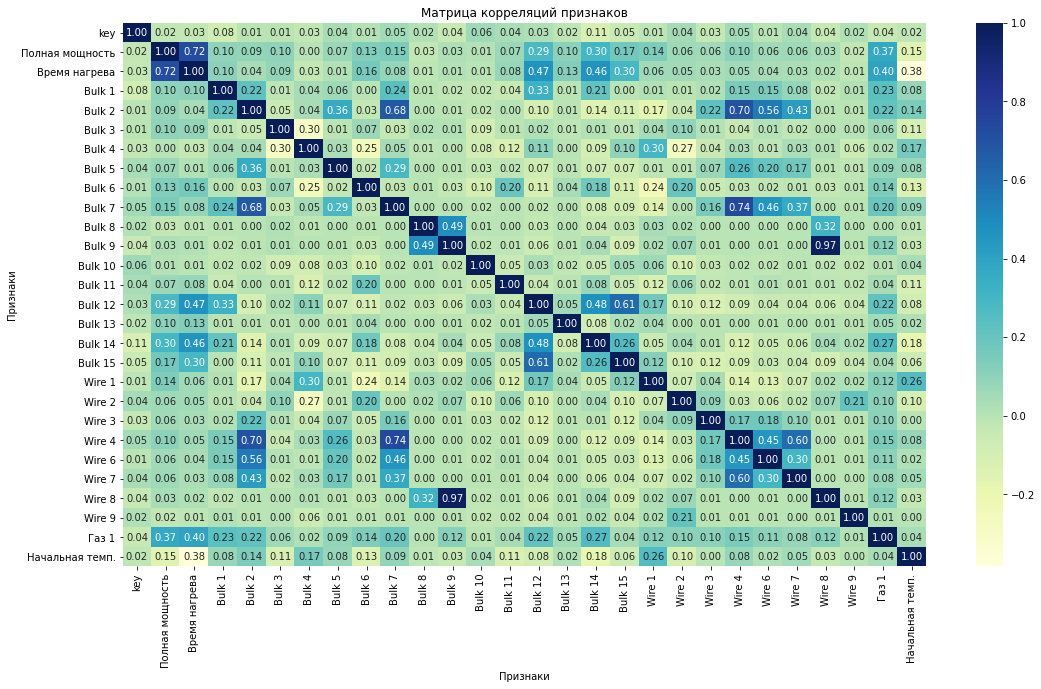

In [66]:
annot_labels = abs(features.corr())
fig, ax = plt.subplots(figsize=(18,10))
dataplot = sns.heatmap(features.corr(), cmap="YlGnBu", annot=annot_labels, annot_kws={"size": 10}, fmt='.2f')
plt.title('Матрица корреляций признаков')
plt.ylabel('Признаки')
plt.xlabel('Признаки')
plt.show()

*Wire 8* и *Bulk 9* коррелируют с показателем 0.97. Удалим один из признаков - *Bulk 9*.

In [68]:
features.drop('Bulk 9', axis=1, inplace=True)
features.head(2)

,key,Полная мощность,Время нагрева,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9,Газ 1,Начальная темп.
0,1,3.718736,1098.0,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,60.059998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.749986,1571.0
1,2,2.588349,811.0,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,96.052315,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.555561,1581.0


Посмотрим, как распределены признаки. Сначала целевой.

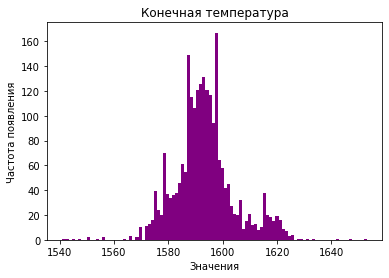

In [69]:
plt.hist(target, bins=100, color='purple');
plt.title('Конечная температура');
plt.xlabel('Значения');
plt.ylabel('Частота появления');
plt.show()

Нормальное распределение с пиками. Возможно, есть несколько значений температур, характерных для разных типов продукта.

Посмотрим на исходные признаки.

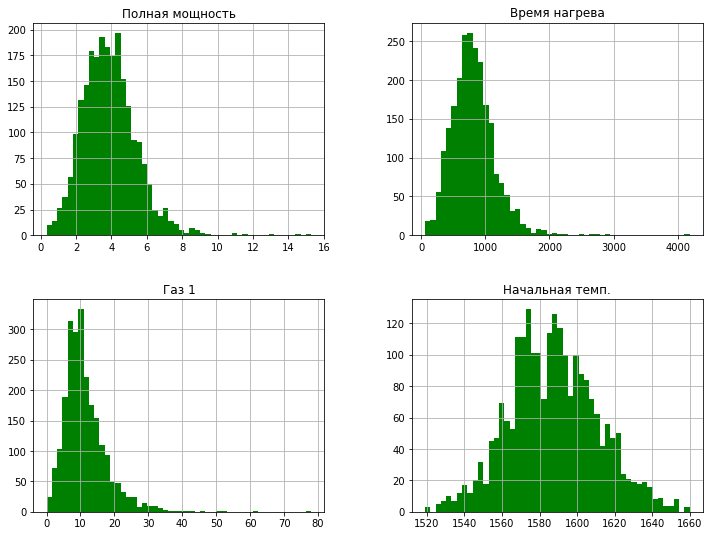

In [70]:
features[['Полная мощность', 'Время нагрева', 'Газ 1', 'Начальная темп.']].hist(
    figsize=(12,9), bins=50, color='green');

Тоже нормальные распределения. У всех, кроме температуры, хвосты из выбросов. 

Наконец, добавки.

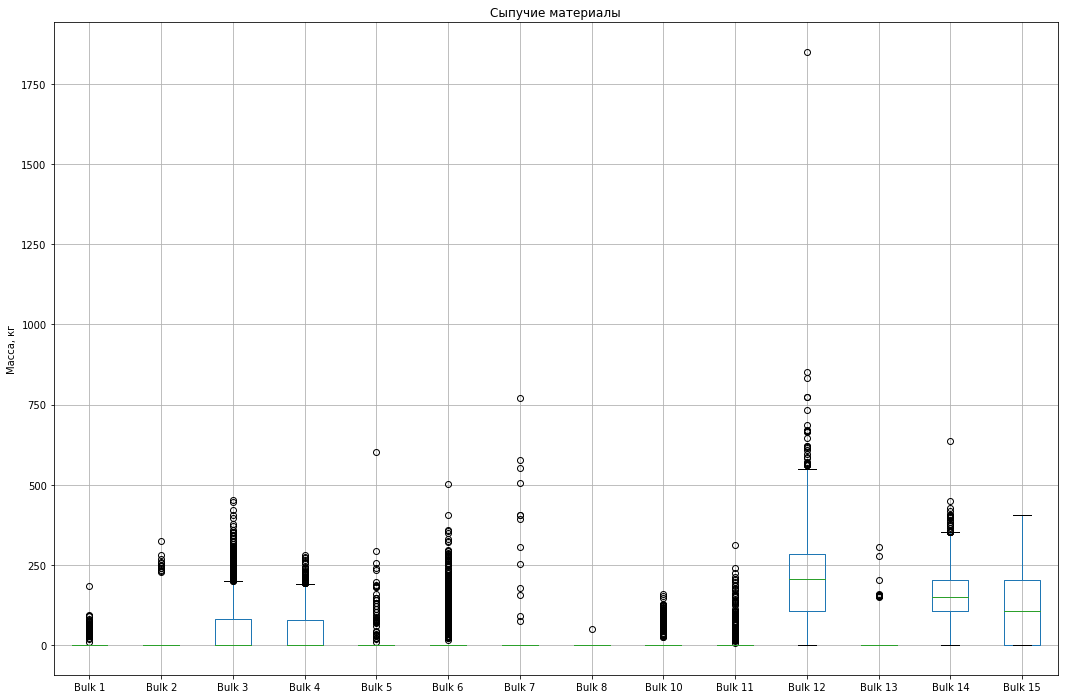

In [71]:
bulk_columns = [x for x in features.columns if 'Bulk' in x]
plot = features.loc[:, bulk_columns].boxplot(figsize = (18,12));
plt.title('Сыпучие материалы');
plt.ylabel('Масса, кг')
plt.show()

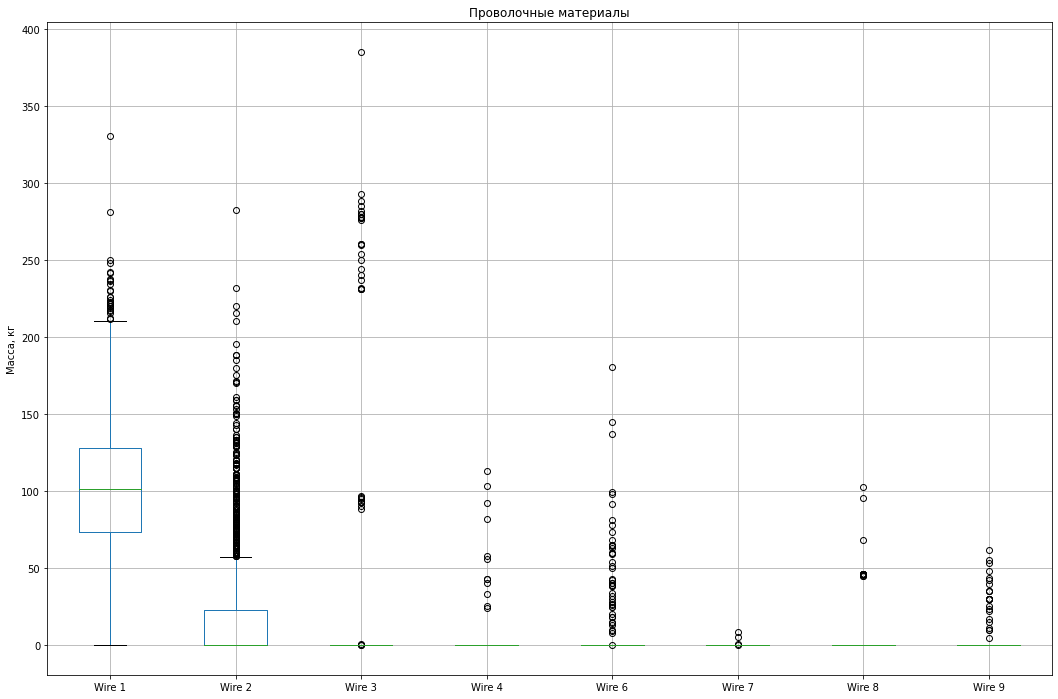

In [72]:
wire_columns = [x for x in features.columns if 'Wire' in x]
plot = features.loc[:, wire_columns].boxplot(figsize = (18,12));
plt.title('Проволочные материалы');
plt.ylabel('Масса, кг')
plt.show()

Суммирование по партиям сделало распределения у'же, но, в целом, ничего особо не изменилось.

Разделим признаки и таргет на обучающую и тестовую выборки.

In [73]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=RANDOM_STATE, shuffle=True)

In [74]:
for df in [X_train, y_train, X_test, y_test]:
    print(df.shape)

(1743, 27)
(1743, 1)
(582, 27)
(582, 1)


##### Вывод по предобработке

В этом разделе были обработаны типы, пропуски, аномалии в данных. Исключены из рассмотрения потенциально бесполезные признаки (времена добавок) и проблемные партии. Все таблицы сгруппированы по номеру партии и объединены в один датасет. Из этого датасета удален пустой признак - *Wire 5*, а также признак, имевший сильную корреляцию с другим - *Bulk 9*. Всего удалены данные по 3239-2325=914 партиям.

### Обучение моделей

Подготовим инструменты.

In [75]:
models = ['Linear', 'RFR', 'LGBM', 'XGB']
result_list = []

In [76]:
scaler = StandardScaler()
score = make_scorer(mean_absolute_error, greater_is_better = False)

In [77]:
#модели
model_LR = Pipeline([('Sclr', scaler), ('rgsr', LinearRegression())])
model_RFR = RandomForestRegressor(random_state=RANDOM_STATE)
model_LGBM = LGBMRegressor(random_state=RANDOM_STATE)
model_XGB = xgb.XGBRegressor(random_state=RANDOM_STATE)

In [78]:
#функция для работы модели с подбором параметров
def model_run(model, params, x_train, y_train):
    model_opt = GridSearchCV(model, params, cv=5, n_jobs=-1, scoring=score, verbose=10)
    model_opt.fit(x_train, y_train)
    return model_opt.best_score_, model_opt.best_estimator_  

Сначала обучим линейную регрессию, чтобы провести baseline.

In [79]:
mae_lr = cross_val_score(model_LR, X_train, y_train, cv=5, scoring=score, n_jobs=-1)
result_list.append(round(mae_lr.mean()*-1, 2))
print(round(mae_lr.mean()*-1, 2))

6.57


Уже неплохо, но, возможно, можно лучше.

Остальные модели требуют подбора параметров.

In [80]:
#параметры
param_RFR = {'n_estimators': [700, 800, 900], 'max_depth': [11, 12, 13, 14], 
             'random_state': [RANDOM_STATE], 'min_samples_split': [7, 8, 9, 10]}
param_LGBM = {'n_estimators': [20, 45, 50, 55, 70], 'max_depth': [7, 8, 9, 10, 13], 
             'random_state': [RANDOM_STATE]}
param_XGB = {'learning_rate': [0.07, 0.1, 0.12, 0.2], 'max_depth': [1, 3, 4, 5], 
             'lambda': [0.00001, 0.0001, 0.0005, 0.001, 0.1], 'random_state': [RANDOM_STATE]}

In [81]:
%%time
result_RFR = model_run(model_RFR, param_RFR, X_train, y_train)
result_list.append(round(result_RFR[0]*-1, 2))
print(result_RFR)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV 1/5; 1/48] START rgsr__max_depth=11, rgsr__min_samples_split=7, rgsr__n_estimators=700, rgsr__random_state=250923
[CV 1/5; 1/48] END rgsr__max_depth=11, rgsr__min_samples_split=7, rgsr__n_estimators=700, rgsr__random_state=250923; total time=   5.4s
[CV 2/5; 1/48] START rgsr__max_depth=11, rgsr__min_samples_split=7, rgsr__n_estimators=700, rgsr__random_state=250923
[CV 2/5; 1/48] END rgsr__max_depth=11, rgsr__min_samples_split=7, rgsr__n_estimators=700, rgsr__random_state=250923; total time=   5.4s
[CV 3/5; 1/48] START rgsr__max_depth=11, rgsr__min_samples_split=7, rgsr__n_estimators=700, rgsr__random_state=250923
[CV 3/5; 1/48] END rgsr__max_depth=11, rgsr__min_samples_split=7, rgsr__n_estimators=700, rgsr__random_state=250923; total time=   5.4s
[CV 4/5; 1/48] START rgsr__max_depth=11, rgsr__min_samples_split=7, rgsr__n_estimators=700, rgsr__random_state=250923
[CV 4/5; 1/48] END rgsr__max_depth=11, rgsr__min_samples_s

In [82]:
%%time
result_LGBM = model_run(model_LGBM, param_LGBM, X_train, y_train)
result_list.append(round(result_LGBM[0]*-1, 2))
print(result_LGBM)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5; 1/25] START rgsr__max_depth=7, rgsr__n_estimators=20, rgsr__random_state=250923
[CV 1/5; 1/25] END rgsr__max_depth=7, rgsr__n_estimators=20, rgsr__random_state=250923; total time=   0.2s
[CV 2/5; 1/25] START rgsr__max_depth=7, rgsr__n_estimators=20, rgsr__random_state=250923
[CV 2/5; 1/25] END rgsr__max_depth=7, rgsr__n_estimators=20, rgsr__random_state=250923; total time=   0.3s
[CV 3/5; 1/25] START rgsr__max_depth=7, rgsr__n_estimators=20, rgsr__random_state=250923
[CV 3/5; 1/25] END rgsr__max_depth=7, rgsr__n_estimators=20, rgsr__random_state=250923; total time=   0.4s
[CV 4/5; 1/25] START rgsr__max_depth=7, rgsr__n_estimators=20, rgsr__random_state=250923
[CV 4/5; 1/25] END rgsr__max_depth=7, rgsr__n_estimators=20, rgsr__random_state=250923; total time=   0.2s
[CV 5/5; 1/25] START rgsr__max_depth=7, rgsr__n_estimators=20, rgsr__random_state=250923
[CV 5/5; 1/25] END rgsr__max_depth=7, rgsr__n_estimators=20, rgsr

In [83]:
%%time
result_XGB = model_run(model_XGB, param_XGB, X_train, y_train)
result_list.append(round(result_XGB[0]*-1, 2))
print(result_XGB)

Fitting 5 folds for each of 80 candidates, totalling 400 fits
[CV 1/5; 1/80] START rgsr__lambda=1e-05, rgsr__learning_rate=0.07, rgsr__max_depth=1, rgsr__random_state=250923
[CV 1/5; 1/80] END rgsr__lambda=1e-05, rgsr__learning_rate=0.07, rgsr__max_depth=1, rgsr__random_state=250923; total time=   9.1s
[CV 2/5; 1/80] START rgsr__lambda=1e-05, rgsr__learning_rate=0.07, rgsr__max_depth=1, rgsr__random_state=250923
[CV 2/5; 1/80] END rgsr__lambda=1e-05, rgsr__learning_rate=0.07, rgsr__max_depth=1, rgsr__random_state=250923; total time=  11.9s
[CV 3/5; 1/80] START rgsr__lambda=1e-05, rgsr__learning_rate=0.07, rgsr__max_depth=1, rgsr__random_state=250923
[CV 3/5; 1/80] END rgsr__lambda=1e-05, rgsr__learning_rate=0.07, rgsr__max_depth=1, rgsr__random_state=250923; total time=   5.7s
[CV 4/5; 1/80] START rgsr__lambda=1e-05, rgsr__learning_rate=0.07, rgsr__max_depth=1, rgsr__random_state=250923
[CV 4/5; 1/80] END rgsr__lambda=1e-05, rgsr__learning_rate=0.07, rgsr__max_depth=1, rgsr__random_sta

In [84]:
result_tab = pd.DataFrame({'MAE': result_list}, index=models)
result_tab

,MAE
Linear,6.57
RFR,6.40
LGBM,6.33
XGB,6.29


##### Вывод по моделям

Все модели преодолели заданный порог. Лучший показатель на тренировочной выборке - у XGB. Проверим его работу на тестовой.

### Тестирование

Проверим лучшую модель на тестовой выборке.

In [85]:
result = result_XGB[1].predict(X_test)
mae = mean_absolute_error(y_test, result)
round(mae, 2)

5.66

Результат удовлетворителен.

Посчитаем дополнительно коэффициент детерминации.

In [86]:
r2 = r2_score(y_test, result)
round(r2, 2)

0.46

R2 маловат. Это означает, что модель недостаточно хорошо уловила связи между признаками и таргетом. Возможно, большее количество данных поможет с этим справиться. Дополнительные признаки тоже могли бы помочь: например, масса стали в партии и температура окружающей среды.

Получим важность признаков для выбранной модели.

In [87]:
importances = result_XGB[1][1].feature_importances_
forest_importances = pd.Series(importances, index=features.columns)

Визуализируем признаки в порядке убывания важности.

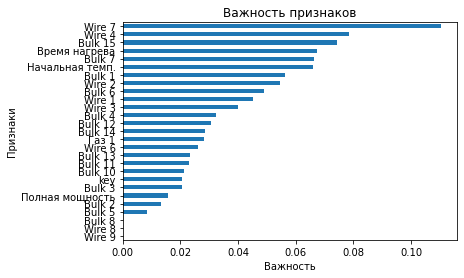

In [88]:
forest_importances.sort_values().plot(kind='barh');
plt.title('Важность признаков');
plt.xlabel('Важность');
plt.ylabel('Признаки');
plt.show()

Проверим адекватность модели сравнением с константной.

In [89]:
dummy = DummyRegressor()
dummy.fit(X_train, y_train);
result_Dummy = dummy.predict(X_test)
mae_Dummy = mean_absolute_error(y_test, result_Dummy)
round(mae_Dummy, 2)

7.41

Модель адекватна.

### Вывод

**В проекте были рассмотрены табличные данные об обработке стали - мощности, добавки, объем газа, замеры температуры. В данных имелись пропуски, аномалии, неподходящие типы данных. Во всех таблицах был общий признак - номер партии.**

**Задачей было предсказать конечную температуру, используя все остальные признаки. Критерием выполнения была MAE не больше 6.8.**

**Для решения задачи было сделано следующее:**

- Выполнена предобработка данных, в рамках которой были обработаны или при необходимости удалены пропуски и аномалии, приведены типы данных. Также были созданы новые признаки - время нагрева и полная мощность. Партии, входившие не во все таблицы, были исключены из рассмотрения. Все таблицы были сгруппированы по общим номерам партий и объединены в один датафрейм. Из этого датафрейма был удален один признак, имевший сильную корреляцию с другим. Наконец датфрейм был разделен на обучающую и тестовую выборки в отношении 3:1.
- Обучены модели: сначала линейная регрессия, потом случайный лес и два бустинга (LGBM и XGB) с подбором гиперпараметров. Лучшую MAE на тренировочной выборке продемострировал XGB.
- Выбранная модель была проверена на адекватность константной моделью, важность признаков визуализирована. **MAE на тестовой выборке составила 5.66.**